# Power Production - Machine Learning project

The assignment project for Machine Learning and Statistics, GMIT 2020-2021

Lecturer: Dr. Ian McLoughlin

>Author: **Andrzej Kocielski**  
>Github: [andkoc001](https://github.com/andkoc001/)  
>Email: G00376291@gmit.ie, and.koc001@gmail.com


This Notebook should be read in conjunction with the corresponding README.md file at the project [repository](https://github.com/andkoc001/Machine-Learning-and-Statistics-Project.git) at GitHub.

## To do rough plan

`delete me once job done`

- Project intro
- Do research on wind power - write a short paragraph on findings  
- Exploratory analysis the raw data set  
    - add zones A, B, C, D to the plot
- Pick one - linear regression - ML algorithm and apply to the data set - explain the model  
- Pick another ML algorithm - Neural Networks regression - apply and explain the model
- Perform accuracy analysis of the predictions  
- Write a python script to run the web service (use pickle module?)  
- Write a brief conclusion
- Style the web service

</br>

## Introduction

___

### Project objectives

The objective of the is to develop a web service to make predictions using Machine Learning (ML) paradigm. 

The goal of the project is to produce a model or models that, based on the provided dataset `powerproduction`, and through applying the appropriate ML techniques, predicts power output generated by wind turbine from wind. The power output predictions should be generated in response to wind speed values to be obtained as HTTP requests.

Further details can be found in the [project brief](https://github.com/andkoc001/Machine-Learning-and-Statistics/blob/main/assessment.pdf).

### Project delivery

The project is about development of a machine learning model(s) in Jupyter Notebook environment, using existing algorithms and tools, such as Keras, TensorFlow or Scikit learn packages. The model(s) are assesst on their accuracy.

Based on the model(s), a Python script is developed to run a web service, using Flask package. The web service is built in a Docker container. 

### Wind Power

Wind power (or wind energy) is a general term describing energy generated from wind, where the wind kinetic enrgy is converted into electrical power. Typically, the power is generated in wind turbins.

There is many factors influencing the generated output, but wind speed is a fundamental contributor. Wikipedia article states that the power is proportional to the third power of the wind speed ([Wind power](https://en.wikipedia.org/wiki/Wind_power)):

$$
P = \frac{1}{2} A \rho v^3
$$

where $P$ is the power output, $A$ corresponds to the size of the turbin, $\rho$ is the air density and $v$ is the wind speed.

However, in practical terms, the observed power output follows a more complex pattern ([Wind education - Wind power](https://energyeducation.ca/encyclopedia/Wind_power)).

![https://qph.fs.quoracdn.net/main-qimg-dab018104232374e846a9e47c7b5434e.webp](https://qph.fs.quoracdn.net/main-qimg-dab018104232374e846a9e47c7b5434e.webp) Image source: ([Quora - What is a power curve](https://www.quora.com/What-is-a-power-curve-and-how-do-we-draw-one))

The wind turbin activates on a certain treshold wind speed - cut-in speed. Below that speed the turbin operation is not economically viable. 

The maximum power output is achieved at the rated wind speed - turbin specific. In the zone between the cut-in and rated speeds, the power increases exponencially with the wind speed. 

Behind the rated speed, the produced output remains approximately flat (or may decline gently), until it reaches the cut-off speed. At such speed, the turbine is shut down in order to prevent them from taking damege. 

It is also worth noting that the above power curve is only a crude approximation of the observed amount of energy produced in reality. 

</br>

## Setting the environment

___

This notebook documents the project development. Please also refer to README.md file in this repository for general information.

### Importing required libraries

For this project the external packages and modules are used. All of them are imported in the cell(s) below. It is required to import the packages and modules before running the succeding cells.

1. Numpy - for numerical operations on arrays
2. Pandas - for DataFrame data type
3. Scikit-learn (aka sklearn) - for Machine Learning algorithms
4. Matplotlib - for plotting and visualisation
5. Seaborn - for enhanced plotting and visualisation

In [1]:
# ignore deprecated warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages - see description above
from math import sqrt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set plotting style
plt.style.use('ggplot')
# set default figure size
plt.figure(figsize=(14,8))
plt.rcParams["figure.figsize"] = (14,8)
# plot matplotlib graphs next to the code
%matplotlib inline

### Loading the data set from a file

The data set provided for the project is loaded from the file powerproduction.txt (in the repository). It is stored as a DataFrame and assigned under the name `df_raw`.

In [4]:
# load the data set from file
df_raw = pd.read_csv(r"powerproduction.txt")

### A glance into the data set

The dataset loaded from the provided file is assigned to variable `df_raw`. Let us take a sneak peek as to how this dataset looks like. We will attempt to evaluate its size, basic statistical properties, distributions, etc. as well as produce some plots for a better understanding of its properties.  

In [5]:
# show the data set
# df_raw # commented out not to clutter the notebook

In [6]:
# rudimentary statistical insight into the data set
df_raw.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


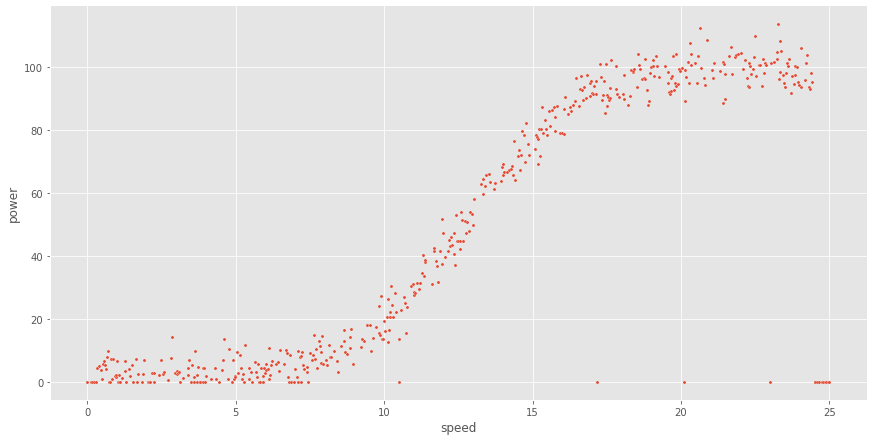

In [7]:
# plot the data points
sns.relplot(data=df_raw, x="speed", y="power", s=10, height=6, aspect=2)

### Exploratory data analysis

From the above dataset description and data points plot, the following conclusions can be drawn.

The data set consist of 500 observations (rows). Each observation consists of 2 attributes (columns): wind speed (`speed`) and corresponding power output (`power`). The units of the values are not explicitly given. Possibly the wind speed is shown in m/s, whereas power values represents the turbin efficiency.

The wind speed values varies from 0 to 25 and are shown in ascending order. Every speed value is unique. The power output values varies from 0 to 113.556. There are 49 instances (approximatelly 10% of all observations) where the power output equals zero.

From the plot one can observe three distinct areas with different behaviour of the data points. I will refer to them as zones A, B, C and D.

A - The wind speed ranging from 0 to about 8.  
B - In wind speed range from about 8 to about 17.  
C - The wind speed between approximately 17 and 24.5.  
D - Above wind speed level of 24.5.

Such a behaviour agrees closely with the wind power curve shown above ([Wind education - Wind power](https://energyeducation.ca/encyclopedia/Wind_power)). It can be explained by the fact that at low wind speed - in zone A - the wind does not carry sufficient energy to turn the turbines or it is not economically justified. The genreated power output readings are not affected by the wind speed in this region. These readings may be caused by other factors (noise). For this analyis, however, it is assumed these are valid output readings.  
In zone B there is a nearly linear (even close to exponencial) correlation between the wind speed and the power output.  
When wind speed exceeds approximately 17, the wind turbines work with a high performance, close to its 100% efficiency. However, the power output declines slightl with incrasing wind speed, up to approximately 24.5 - zone C.  
In the zone D where the winds are very strong, the power output is not produced. The power generation abruptly ceases, possibly because the turbines are shut off for safety reasons.

(-5.0, 120.0)

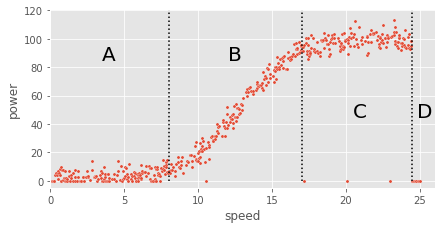

In [8]:
sns.relplot(data=df_raw, x="speed", y="power", s=10, height=3, aspect=2)
plt.plot([8,8],[0,120], "k:")
plt.plot([17,17],[0,120], "k:")
plt.plot([24.5,24.5],[0,120], "k:")
plt.text(3.5, 85, "A", size='20', color='black')
plt.text(12, 85, "B", size='20', color='black')
plt.text(20.5, 45, "C", size='20', color='black')
plt.text(24.8, 45, "D", size='20', color='black')
plt.xlim(0,26)
plt.ylim(-5,120)

Occasionally, there is a number of observations where the power output is zero, even though the wind speeds are in zones allowing for producing the power. In total, there is 49 observations with power output equal to zero. It is assumed these data points represent observations during, for example, maintenance works, when the turbin was shut down.

In [9]:
# There is 49 (about 10%) of the observation with zero power output 
df_raw[df_raw.power == 0].count()

speed    49
power    49
dtype: int64

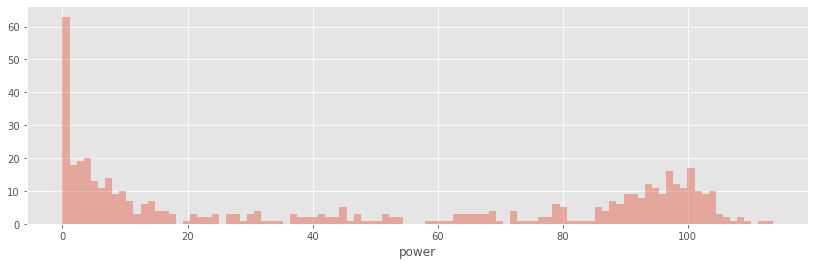

In [10]:
# Histogram of power outputs - frequency of occurance - 'zero' values seem to distort the plot
plt.rcParams["figure.figsize"] = (14,4)
sns.distplot(df_raw.power, bins=100, kde=False)
plt.show()

The analysis of the wind speed distribution shows that the wind speed appears to uniformly distribute, with no particular wind speed dominating.

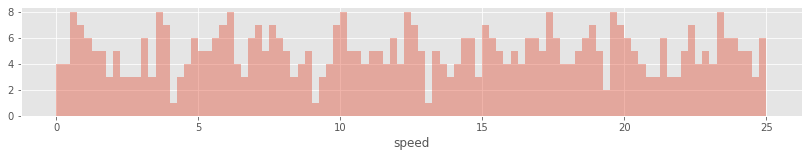

In [11]:
# what wind speeds dominate - it appears to be more or less uniformely distributed
plt.rcParams["figure.figsize"] = (14,2)
sns.distplot(df_raw.speed, bins=100, kde=False)
plt.show()

### Clean the dataset

The observations where the power output is zero spread randomly along the wind speeds. The data points seem to distort data set. These points are therefore assumed to be data anomaly and excluded from further analysis.

The data set is now cleand by removal of these observations from the dataset. A new dataframe `df` is created.

In [12]:
# clean the dataset by removing all observations where the power output is zero
df = df_raw[df_raw['power'] !=0]

### The problem

In terms of the machine learning, thes is a regression problem. The objective of this project is to apply machine learning techniques in order to forecast a responce of the power output (independent variable) based on a given wind speed (dependent variable). The provided data set is composed out of two variables (features). As the variables are continues in nature (in contrast to categorical) and unlabeled, the task requires application of unsupervised learning ([Real Python - Linear Regression in Python](https://realpython.com/linear-regression-in-python/)). 

</br>

## Simple linear regression

___

Simple linear regression is one of the simplest supervised learning algorithms in machine learning and is widely used for forecasting. The aim of the linear regression is  to fit a stight line to the data ([https://en.wikipedia.org/wiki/Linear_regression](https://en.wikipedia.org/wiki/Linear_regression)). In this section, sklearn library is used. This section of the project is based on [Alaettin Serhan Mete - Linear regression - exercise project](https://amete.github.io/DataSciencePortfolio/Udemy/Python-DS-and-ML-Bootcamp/Linear_Regression_Project.html).

The entire data set is first devided into variable `X` that holds the wind speed values and a variable `y` equal to the power outputs. Next, the data is split into training and testing sets. The training set is formed out of 70% random instances from the whole (cleaned) data set and the test data - out of remaing 30%. 

A linear regression model, called `lin_reg_model`, is built and trained on the training sets X and y.

In [13]:
# assign "speed" and "power" sets to variables X and y
X, y = df["speed"], df["power"]

# random_state (seed) is set for consistancy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

In [14]:
# convert the array shape and unify the lengths
X_train = X_train.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)

# create an instance of a LinearRegression() model named lin_reg_model.
lin_reg_model = LinearRegression()

#Train/fit lin_reg_model on the training data.
lin_reg_model.fit(X_train, y_train)



LinearRegression()

### Model evaluation

Let's see the model parameters: the coefficient and intercept. The meaning of the model coefficient is that for each x-value increase by 1, the predicted response increases by coefficient. The intercept is the value where the regression line crosses the y-axis.

In [15]:
# coefficient of the model (slope)
print(f"The model coefficient (slope) is {float(lin_reg_model.coef_):.2f}")

# intercept value
print(f"Intercept: {float(lin_reg_model.intercept_):.1f}")

The model coefficient (slope) is 5.64
Intercept: -19.9


### Prediction

Prediction of the test values will allow to evaluate the model's performance. 

Function `predict()` is used to predict the `X_test` set of the data. Then, the predictions of the test values will be ploted against the real test values versus.

In [16]:
# reschape X_test
X_test = X_test.values.reshape(-1,1)

predictions = lin_reg_model.predict(X_test)

(-20.0, 120.0)

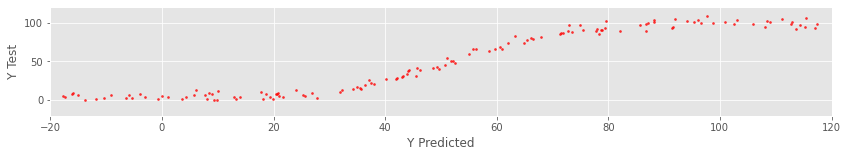

In [17]:
# plot the results
plt.scatter(predictions, y_test, s=4, color='red', alpha=.8)
plt.xlabel('Y Predicted')
plt.ylabel('Y Test')
plt.rcParams["figure.figsize"] = (8,8)
plt.xlim(-20,120)
plt.ylim(-20,120)

In [18]:
# take a random wind speed value from the provided data set (cleaned)
wind_test = df["speed"].sample()

# link corresponding actual power output
for i in range(df.shape[0]):
    if df.iloc[i]["speed"] == wind_test.iloc[0]:
        actual_output = df.iloc[i]["power"]
        
power_predict = lin_reg_model.predict([wind_test])
print(f"The predicted power output for wind speed {float(wind_test):.3f} is: \t {float(power_predict):.3f}")
print(f"The actual power output for wind speed {float(wind_test):.3f} is: \t {float(actual_output):.3f}")
print(f"The prediction accuracy for the data point is: \t\t {float(abs(1.-(abs(power_predict-actual_output)/actual_output))*100):.1f}%")

The predicted power output for wind speed 5.430 is: 	 10.677
The actual power output for wind speed 5.430 is: 	 0.929
The prediction accuracy for the data point is: 		 949.3%


In [19]:
# accuracy of the test set
predictions = predictions.flatten()

print(f"Root mean square error (RMSE): {mean_squared_error(y_test, predictions, squared=False):.3f} \t(by hand: {sqrt((1./len(y_test))*(sum((y_test-predictions)**2))):.3f})")
print(f"Coefficient of determination (R square): {r2_score(y_test, predictions):.2f}") # true value, predicted value

Root mean square error (RMSE): 12.991 	(by hand: 12.991)
Coefficient of determination (R square): 0.89


### Conclusion

Simple linear regression (first polynomial order), offers only a crude approximation. The accuracy for the given data set is resonable only in some limited ranges of wind speed. The simple linear regressiong should be used with much care as the results may be grossly wrong. The model can even yield a negative power output from certain wind speeds! 

</br>

## Polynomial regression

___

Better results, when comparing to simple linear regression, can be produced from higher order polynomial regressions. I have tried various polynomial orders of regression from 1st up to 15th order. Some of them are shown in below plot. Even though regression of lower polynomial are still suseptible to underfitting approximation, they appear to be significantly better simple linear regression. At the same time, higher polynomial order regression tend to excessive complexity and may lead to the risk of overfitting.

Several polynomials of various order has been tested. The 7th order seems to provide a good accuracy in the wind speed between 0 and 24.5, as shown below in solid blue line.

In [20]:
# reshape the array
X = df.iloc[:, 0].values.reshape(-1,1)
# y = df.iloc[:, 1].values.reshape(-1,1)
y = df.iloc[:, 1]

In [1]:
# adapted from https://stackoverflow.com/q/51732577
plt.scatter(X, y, s=2, color='red', alpha=1.0, label="data")

# Fitting Polynomial Regression to the dataset
poly_reg = PolynomialFeatures(degree = 1)
X_poly = poly_reg.fit_transform(X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
plt.plot(X, lin_reg.predict(X_poly), ls="--", color = 'green', alpha=0.5, label='1st polynomial order')

poly_reg = PolynomialFeatures(degree = 3)
X_poly = poly_reg.fit_transform(X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
plt.plot(X, lin_reg.predict(X_poly), ls="--", color='cyan', alpha=0.6, label='3rd polynomial order')

poly_reg = PolynomialFeatures(degree = 7)
X_poly = poly_reg.fit_transform(X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
plt.plot(X, lin_reg.predict(X_poly), ls="-", color='red', alpha=1.0, label='7th polynomial order')

poly_reg = PolynomialFeatures(degree = 20)
X_poly = poly_reg.fit_transform(X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
plt.plot(X, lin_reg.predict(X_poly), ls="--", color='black', alpha=.5, label='20th polynomial order')

# Visualising the Polynomial Regression results
plt.legend(loc='best')
plt.rcParams["figure.figsize"] = (14,8)
plt.show()

NameError: name 'plt' is not defined

### Apply regression model

This section is based on tutorial at [Miroslaw Mamczur - Jak działa regresja liniowa i czy warto ją stosować (in Polish)](https://miroslawmamczur.pl/jak-dziala-regresja-liniowa-i-czy-warto-ja-stosowac/). Again, sklearn package id used to built the regression model. This time, the regression model is develope on the entire data set, without splitting for training and test sets.

The polynomial order=7 appears to closely follow the pattern of the data points in the domain of the wind speed (range 0-24.5). It also appears to be free from overfitting in this range. Therefore I consider it a good candidate for further analysis.

In [22]:
# develop a regression model
poly = PolynomialFeatures(degree = 7) # 7th polynomial order
X_poly = poly.fit_transform(X)
# lin_reg = LinearRegression()
# ask our model to fit the data.
# lin_reg.fit(X_poly, y)
poly_reg = LinearRegression().fit(X_poly, y)
# perform regression to predict the power output out of wind speed
y_pred = poly_reg.predict(X_poly)

print('Coefficients: ', poly_reg.coef_)
print('Intercept: ', poly_reg.intercept_)

Coefficients:  [ 0.00000000e+00 -1.38470256e+01  8.13376871e+00 -2.04365136e+00
  2.50368085e-01 -1.52309426e-02  4.48301902e-04 -5.11800967e-06]
Intercept:  10.914071908334812


Out of curiosity, I have also compared the polynomial coefficients when applying the Numpy's `polyfit()`. This function gets the value of the coefficients that minimise the squared order of the polynomial function. The coefficients and the intercept are the same as those achieved using the sklearn library above.

In [23]:
coeff = np.polyfit(df['speed'], df['power'], 7)
#coeff
yp = np.poly1d(coeff)

print("y = ")
print(yp)

y = 
            7             6           5          4         3         2
-5.118e-06 x + 0.0004483 x - 0.01523 x + 0.2504 x - 2.044 x + 8.134 x - 13.85 x + 10.91


### Predictions

In order to predict the power output in function of the wind speed, the above equation will be used. In the below cell, enter manually wind speed (in the range 0-25) to get the model to calculate the power output.

In [24]:
# enter arbitrary wind speed value in range between 0 and 25
wind_speed = 20

x = wind_speed
power_output = (-5.11800967e-06*pow(x,7)) + 4.48301902e-04*pow(x,6) - 1.52309426e-02*pow(x,5) + 2.50368085e-01*pow(x,4) - 2.04365136e+00*pow(x,3) + 8.13376871e+00*pow(x,2) - 1.38470256e+01*pow(x,1) + 10.91407191*pow(x,0)
print(f"Predicted power output from wind speed = {wind_speed} is: {power_output:.2f}")

Predicted power output from wind speed = 20 is: 98.42


### Accuracy

(-20.0, 120.0)

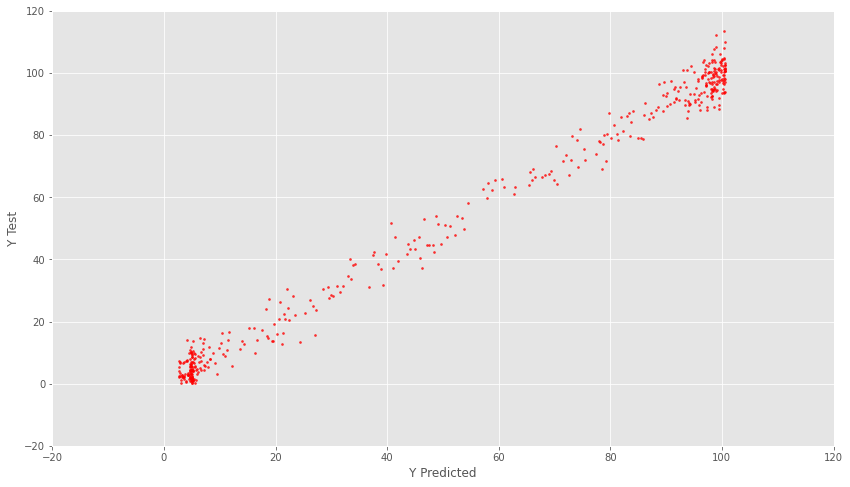

In [25]:
# plot the results
plt.scatter(y_pred, y, s=4, color='red', alpha=.8)
plt.xlabel('Y Predicted')
plt.ylabel('Y Test')
plt.rcParams["figure.figsize"] = (8,8)
plt.xlim(-20,120)
plt.ylim(-20,120)

In [26]:
print('Root Mean Squared Error (RMSE): %.2f'% np.sqrt(mean_squared_error(y, y_pred)))
print('Coefficient of determination (R square): %.2f'% r2_score(y, y_pred)) # true value, predicted value

Root Mean Squared Error (RMSE): 4.05
Coefficient of determination (R square): 0.99


From the above metrics the most important are root mean squared error, being a way to measure the error of a model in predicting quantitative data, and the coefficient of determination. The achieved value of $RMSE=4.05$ is low, suggesting a good model. Also $R^2 = 0.99$ is very close to 1, meaning it is a good fit for the data points.

### Conclusion

Polynomial regressions provide a distinctly better approximation than simple linear regression. The above shown 7th order polynomial gives accurate results and the model does not show overfitting in the considered wind speeds range.

</br>  

## Refs 

---

This project is based predominantly on the lecture materials - not explicitly quoted in the body of the notebook.


#### Wind Power

- [001] [Wikipedia - Wind power](https://en.wikipedia.org/wiki/Wind_power)
- [002] [Wind power - How to calculate power output of wind](https://www.windpowerengineering.com/calculate-wind-power-output)
- [003] [Energy education - Wind power](https://energyeducation.ca/encyclopedia/Wind_power)
- [004] [Wind works - wind turbine rating](http://www.wind-works.org/cms/index.php?id=85&tx_ttnews%5Btt_news%5D=2572&cHash=b74148dbab1938159937a994adf1f05b)


### Regression in Machine Learning

- [001] [Wikipedia - Linear Regression](https://en.wikipedia.org/wiki/Linear_regression)
- [002] [Towards Data Science - Introduction to Machine Learning algorithms: linear regression](https://towardsdatascience.com/introduction-to-machine-learning-algorithms-linear-regression-14c4e325882a)
- [003] [Machine Learning Glossary - Linear regression](https://ml-cheatsheet.readthedocs.io/en/latest/linear_regression.html)
- [004] [Machine Learning Mastery - Linear regression for Machine Learning](https://machinelearningmastery.com/linear-regression-for-machine-learning/)
- [005] [Scikit-learn documentation - Polynomial regression](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions)
- [006] [Miroslaw Mamczur - Jak działa regresja liniowa i czy warto ją stosować (in Polish)](https://miroslawmamczur.pl/jak-dziala-regresja-liniowa-i-czy-warto-ja-stosowac/)
- [007] [Alaettin Serhan Mete - Linear regression - exercise project](https://amete.github.io/DataSciencePortfolio/Udemy/Python-DS-and-ML-Bootcamp/Linear_Regression_Project.html)
- [008] [Real Python - Linear regression in Python](https://realpython.com/linear-regression-in-python/)

#### Pickle

- [001] [Python documentation - Pickle module](https://docs.python.org/3/library/pickle.html)
- [002] [Datacamp - Pickle tutorial](https://www.datacamp.com/community/tutorials/pickle-python-tutorial)
- [003] [Stack Overflow - How to read pickle file](https://stackoverflow.com/a/35068080)
- [004] [YouTube - From Jupyter to pickle](https://youtu.be/3-KOE15utuQ)

#### Docker

- [001] [Docker - What is a container?](https://www.docker.com/resources/what-container)
- [002] [Dataquest - Running a Dockerized Jupyter Server for Data Science](https://www.dataquest.io/blog/docker-data-science)


#### Flask


___
Andrzej Kocielski